In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import pywt
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import itertools
import plotly.graph_objects as go

## Event ID, Device_IDs, File path, time column name, and GIC column name
eventDate = 20131002 # YYYYMMDD

# Get the current working directory + desired directories
parent_directory = os.getcwd()
main_directory = parent_directory + '/drive/MyDrive/2024 UW ENGINE Capstone'
curr_directory = main_directory + '/data/GMD and GIC'
event_directory = curr_directory + '/event_' + str(eventDate) + '/GIC'

In [ ]:
# Location Dataframe for Devices (e.g Latitude / Longitude )
loc_file = event_directory + '/gic_monitors.csv'
loc_df = pd.read_csv(loc_file) # create df for locations based on device ID

# Adjust Dataset by making Longitude Negative (indicating West)
device_IDs = loc_df['Device ID'] # Series
loc_df.rename(columns={' Latitude': 'Latitude'}, inplace=True) # Change column title to remove extra space
loc_df.rename(columns={' Longitude': 'Longitude'}, inplace=True) # Change column title to remove extra space
loc_df['Longitude'] = loc_df['Longitude'] * -1  # create negative for western hemisphere

latitude_dict = pd.Series(loc_df['Latitude'].values, index=loc_df['Device ID']).to_dict()

# Create list of file paths
file_paths = []
file_names = [f for f in os.listdir(event_directory) if f.startswith(str(eventDate)[0:4])]

for file_name in os.listdir(event_directory):
  if file_name.startswith(str(eventDate)[0:4]):
    file_paths.append(event_directory + '/' + file_name)
print(f"Number of Files for Event: {len(file_paths)}")

# View example of file path
print(f"file_paths[0]: '{file_paths[0]}'")
print(f"file_paths: {file_paths}")
print(f"file names: {file_names}")
print(loc_df)

In [ ]:
# HELPER FUNCTIONS

# This function calculates the maximum level of decomposition that can be achieved using Stationary Wavelet Transform (SWT) for a given input data length
def determine_max_level(data_length, wavelet='db4'):
    return pywt.swt_max_level(data_length)


# This function computes the stationary wavelet transform of a given dataset using a specified wavelet
def modwt(data, wavelet, level):
    return pywt.swt(data, wavelet, level=level, start_level=0)

# This function calculates the cross-correlation between two sets of wavelet coefficients.
# The wavelet coefficient is calculated by MODWT and represents the components of the original signal on different frequency scales.
# Here, wt1 and wt2 represent the wavelet coefficients of the two signals on the same scale
# and the function calculates and returns the correlation coefficients of these coefficients on each scale.
def wavelet_cross_correlation(wt1, wt2):
    corrs = []
    for coeff1, coeff2 in zip(wt1, wt2):
        corr = np.corrcoef(coeff1[0], coeff2[0])[0, 1]
        corrs.append(corr)
    return corrs

# This function calculates the cross-correlation of two time series in the sliding window.
# This is often used to study how the correlation of time series changes at different points in time
def sliding_window_cross_correlation(wt1, wt2, window_size=30):

    assert len(wt1) == len(wt2)
    sliding_corrs = []

    for start in range(len(wt1) - window_size + 1):
        end = start + window_size
        window_corr = np.corrcoef(wt1[start:end], wt2[start:end])[0, 1]
        sliding_corrs.append(window_corr)

    return sliding_corrs

# The first function is to obtain a one-time correlation on different scales of the wavelet transform,
# while the second function is to obtain a continuous correlation of the time varying window
def make_length_even(data):
    return data if len(data) % 2 == 0 else np.append(data, data[-1])


In [ ]:
# Initialize modwt_results dictionary
modwt_results = {}
# Initialize edges
edges = []

# Other associated variables
time_column = 'SampleDateTime'
gic_column = 'GICMeasured'

# For each device in the given event
for file_name in file_names:
    file_path = os.path.join(event_directory, file_name)
    df = pd.read_csv(file_path)
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.drop_duplicates(subset=time_column).set_index(time_column)
    df = df.reindex(pd.date_range(start=df.index.min(), end=df.index.max(), freq='T'), method='nearest')
    resampled_df = df.resample('T').mean().interpolate(method='spline', order=3)
    gic_signal = make_length_even(resampled_df[gic_column].values)
    level = determine_max_level(len(gic_signal))     # get the max level of decomposition for given gic_signal
    modwt_result = modwt(gic_signal, 'db4', level)   # conduct wavelet transform based on max level of decomposition
    file_name = file_name.split('/')[-1]
    modwt_results[file_name] = modwt_result

<ipython-input-5-7c44f0442f55>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column])
<ipython-input-5-7c44f0442f55>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column])
<ipython-input-5-7c44f0442f55>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_column] = pd.to_datetime(df[time_column])
<ipython-input-5-7c44f0442f55>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-exp

In [ ]:
print(f'\n(initial modwt results) \n # of device_ids in the event : {len(modwt_results)}\n')

print("The length of wavelet transform coefficients of '2013E02_10056.csv' is:")
print(len(modwt_results['2013E02_10056.csv'][0][0]))
print("The length of wavelet transform coefficients of '2013E02_10121.csv' is:")
print(len(modwt_results['2013E02_10121.csv'][0][0]))



(initial modwt results) 
 # of device_ids in the event : 87

The length of wavelet transform coefficients of '2013E02_10056.csv' is:
1622
The length of wavelet transform coefficients of '2013E02_10121.csv' is:
1622


In [ ]:
desired_length = 1622     # check if time length of each device checks out
filtered_modwt_results = {device_id: modwt_vals for device_id, modwt_vals in modwt_results.items() if len(modwt_vals[0][0]) == desired_length}
print('(Filtered modwt results):')
print(f"# of device_ids (or files) in the event: {len(filtered_modwt_results.keys())}")
print(f"# of time-based coefficients per device in the event: {len(list(filtered_modwt_results.values())[48][0][0])}")  # 48 is a random index for device ID

(Filtered modwt results):
# of device_ids (or files) in the event: 85
# of time-based coefficients per device in the event: 1622


In [ ]:
# Create Edges based on filtered modwt results
edges = []
correlation_threshold = 0.99

# CONDUCT CROSS CORRELATION ANALYSIS using wavelet_cross_correlation (aka. np.corrcoef)
# NOTE: itertools.combinations compares each tuple or key-value pair with every other tuple or key-value pair
for (device_id1, wt1), (device_id2, wt2) in itertools.combinations(filtered_modwt_results.items(), 2):
    cross_corrs = wavelet_cross_correlation(wt1, wt2)
    # print(cross_corrs)
    for corr in cross_corrs:
        if np.abs(corr) > correlation_threshold:
            edges.append((device_id1, device_id2, corr))
print(edges)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[('2013E02_10410.csv', '2013E02_10412.csv', 0.9941452876398037)]


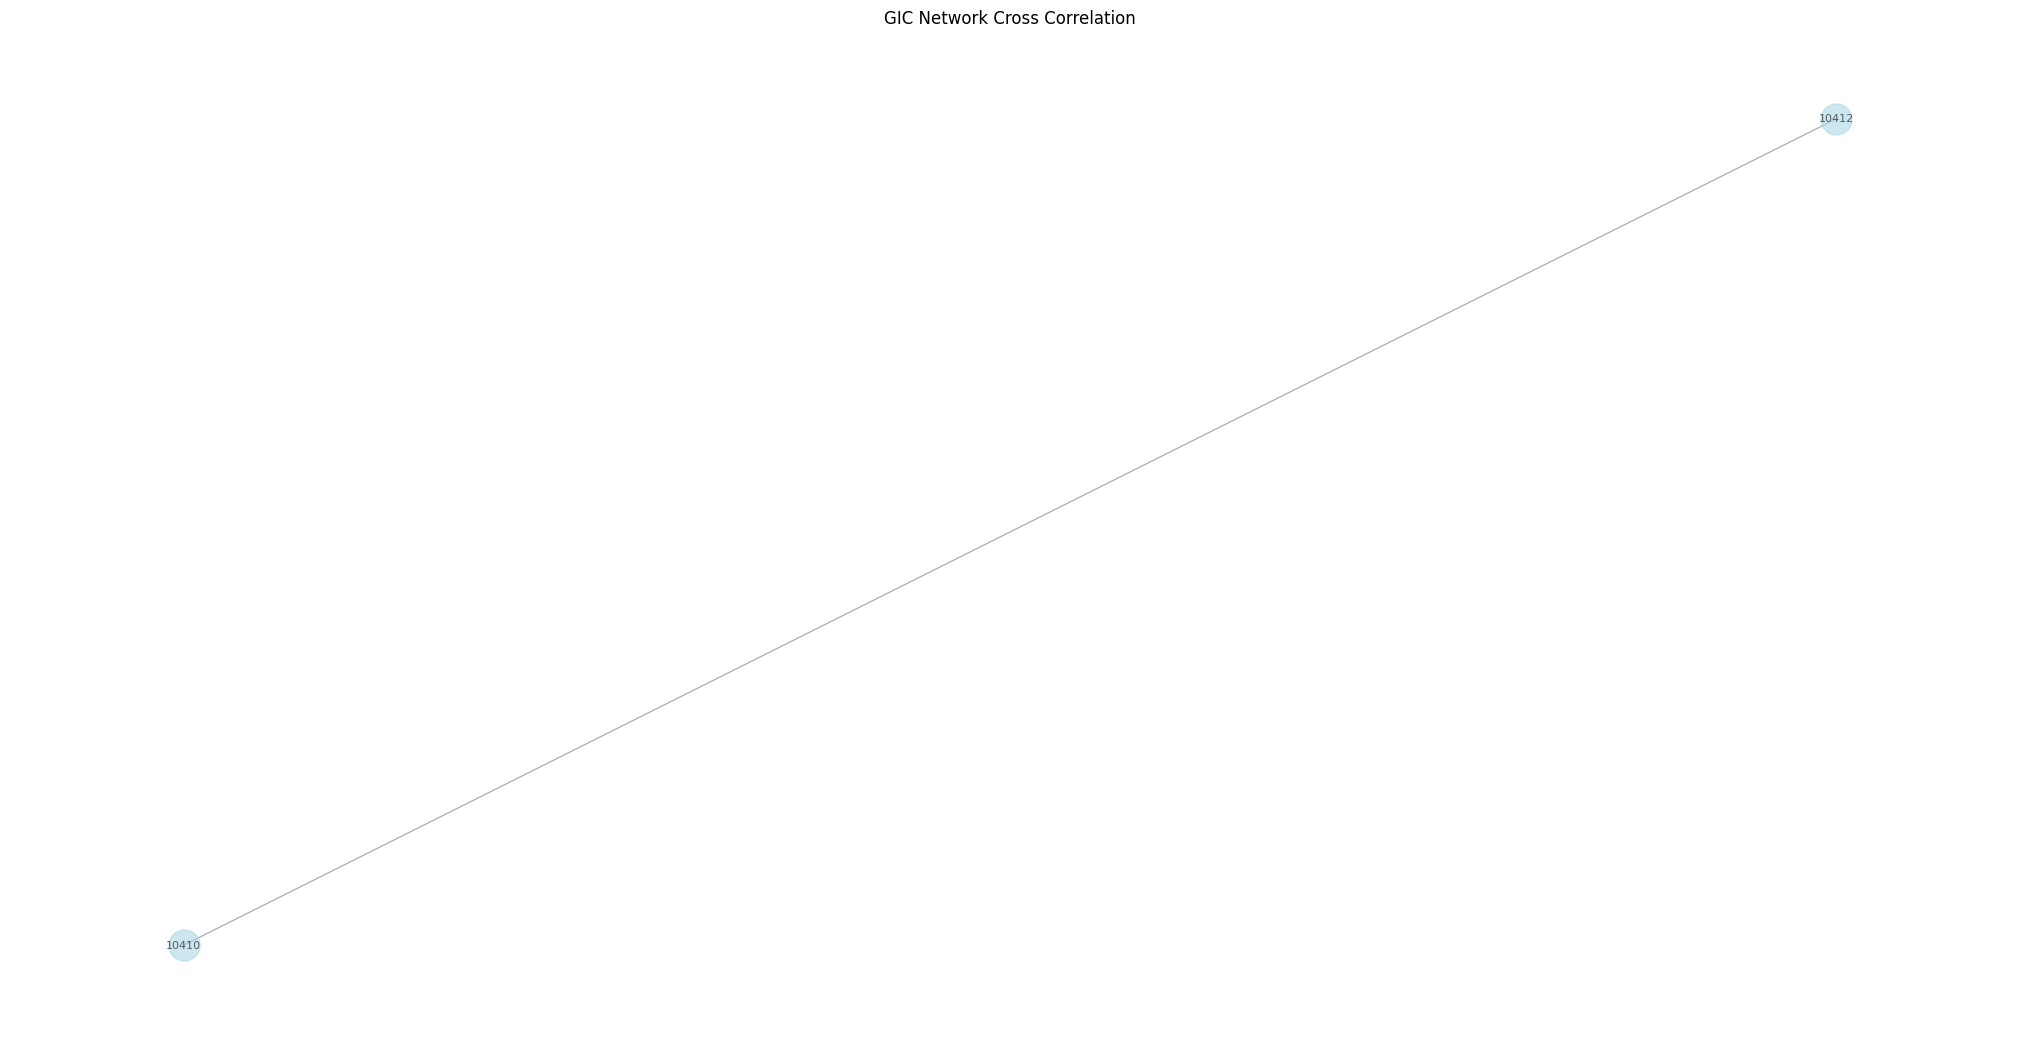

In [ ]:
# Create nx.graph for displaying correlations (non-geographic)
G = nx.Graph()

processed_edges = []
for edge in edges:
    node1, node2, weight = edge
    node1_label = node1.replace('2013E02_', '').replace('.csv', '')
    node2_label = node2.replace('2013E02_', '').replace('.csv', '')
    processed_edges.append((node1_label, node2_label, weight))

G.add_weighted_edges_from(processed_edges)

plt.figure(figsize=(20, 10))  # create plotly figure
pos = nx.spring_layout(G)     # Positions for all nodes

weights = [G[u][v]['weight'] for u, v in G.edges()]

nx.draw(G, pos, width=weights, with_labels=True, node_color='lightblue',
        edge_color='gray', node_size=500, alpha=0.6, font_size=8)

plt.title('GIC Network Cross Correlation')
plt.show()
# This diagram shows a network diagram where the nodes represent different monitors.
# Lines between nodes show correlations between different data sets.
# The more nodes are wired, the higher the correlation with the other data sets.

In [ ]:
# TIME BASED CROSS CORRELATION ANALYSIS BY DORIA
# TIME BASED // Written by Doria
sliding_correlations = {}
window_size = 15

# NOTE: itertools.combinations compares each tuple or key-value pair with every other tuple or key-value pair
for (file1, wt1), (file2, wt2) in itertools.combinations(filtered_modwt_results.items(), 2):
    corrs_over_time = sliding_window_cross_correlation(wt1[0][0], wt2[0][0], window_size)
    sliding_correlations[(file1, file2)] = corrs_over_time

# print(sliding_correlations)


In [ ]:
print(f"# of Device Combinations: {len(sliding_correlations.keys())}")
print(f"# of Device Combinations Values: {len(sliding_correlations.values())}")
print(f"# of Device Combinations Values (Time Series) Coefficient: {len(list(sliding_correlations.values())[35])}")


# of Device Combinations: 3570
# of Device Combinations Values: 3570
# of Device Combinations Values (Time Series) Coefficient: 1608


In [ ]:
# TIME BASED // Written by Doria
# Getting the time axis
file_pair_to_visualize = (file_names[0], file_names[9]) # dummy input
correlations_over_time = sliding_correlations[file_pair_to_visualize]
time_axis = range(len(correlations_over_time))

print(file_pair_to_visualize)
print(correlations_over_time)
print(time_axis)


('2013E02_10083.csv', '2013E02_10077.csv')
[0.14117252440613876, 0.598906313817887, 0.8916523951572829, 0.9202333032056879, 0.9423648249128249, 0.9554723129298902, 0.9336299152002804, 0.8951856113227186, 0.8800055532712219, 0.8391481435304168, 0.7531830952359504, 0.6043132905292085, 0.3792838995601826, 0.1112276385667631, -0.148917459313003, -0.358748684470507, -0.46037596135545394, -0.4078378409961857, -0.3772708747248799, -0.3917329409531868, -0.32735118183007916, -0.053055626588239785, 0.5383522836671424, 0.9297217120262377, 0.9174339752776081, 0.9095273115164386, 0.9184360876934679, 0.9315650877621382, 0.946978618535664, 0.9564997802024123, 0.8670221799820484, 0.6528512204966261, 0.3991769994798916, 0.15093881628136568, -0.09036870695360176, -0.3276926626400524, -0.5303025681240767, -0.6695888161067567, -0.7632556893306819, -0.827425999305976, -0.8458097087556374, -0.7806513097939038, -0.6276990815590343, -0.41447214052229253, -0.17040405045796891, 0.03668675996325239, 6.3824264513

In [ ]:
# Written by Sean Jung
# Create a list of graphs w/ each element over time
G_graphs = [[] for i in range(len(correlations_over_time))]

print(len(sliding_correlations))

# Iterate through each correlation and create graph for each time
# Note: correlations is over time. aka number of correlations over an event tiemframe
for (device_id1, device_id2), correlations in sliding_correlations.items():
    i = 0
    while i < len(correlations_over_time):
      # print(i, correlations[i])
      if abs(correlations[i]) > correlation_threshold:
        G_graphs[i].append((device_id1, device_id2, correlations[i]))
      i += 1


3570


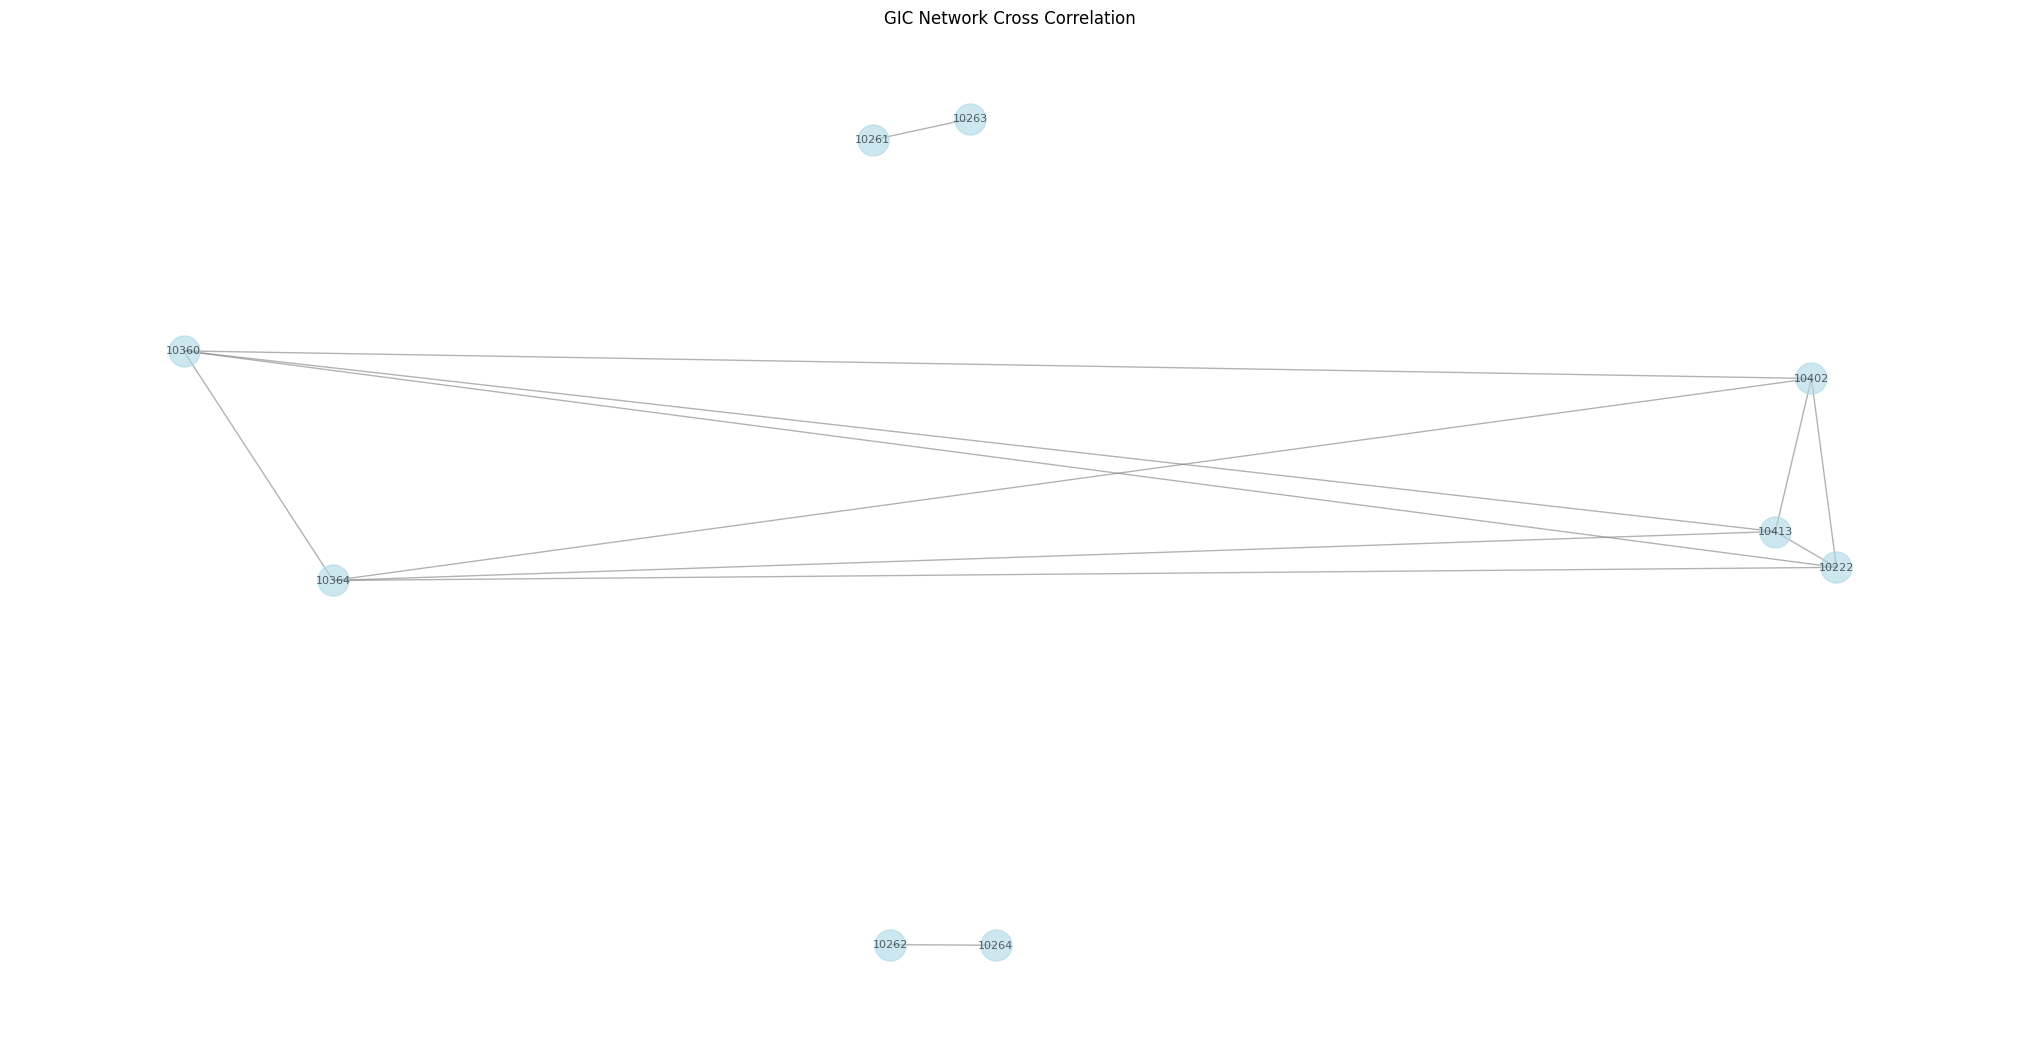

In [ ]:
# Create nx.graph for displaying correlations (non-geographic)
G = nx.Graph()

x_time = 2

processed_edges = []
for edge in G_graphs[x_time]:
    node1, node2, weight = edge
    node1_label = node1.replace('2013E02_', '').replace('.csv', '')
    node2_label = node2.replace('2013E02_', '').replace('.csv', '')
    processed_edges.append((node1_label, node2_label, weight))

G.add_weighted_edges_from(processed_edges)

plt.figure(figsize=(20, 10))  # create plotly figure
pos = nx.spring_layout(G)     # Positions for all nodes

weights = [G[u][v]['weight'] for u, v in G.edges()]

nx.draw(G, pos, width=weights, with_labels=True, node_color='lightblue',
        edge_color='gray', node_size=500, alpha=0.6, font_size=8)

plt.title('GIC Network Cross Correlation')
plt.show()
# This diagram shows a network diagram where the nodes represent different monitors.
# Lines between nodes show correlations between different data sets.
# The more nodes are wired, the higher the correlation with the other data sets.

In [ ]:
# Centrality Measures of response grid (NERC GIC)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

print(f"closeness centrality: {closeness_centrality}")
print(f"betweeness centrality: {betweenness_centrality}")
print(f"eigenvector_centrality: {eigenvector_centrality}")


closeness centrality: {'10261': 0.125, '10263': 0.125, '10222': 0.5, '10364': 0.5, '10360': 0.5, '10402': 0.5, '10413': 0.5, '10262': 0.125, '10264': 0.125}
betweeness centrality: {'10261': 0.0, '10263': 0.0, '10222': 0.0, '10364': 0.0, '10360': 0.0, '10402': 0.0, '10413': 0.0, '10262': 0.0, '10264': 0.0}
eigenvector_centrality: {'10261': 1.200479854370848e-06, '10263': 1.200479854370848e-06, '10222': 0.4472135954986689, '10364': 0.4472135954986689, '10360': 0.4472135954986689, '10402': 0.4472135954986689, '10413': 0.4472135954986689, '10262': 1.200479854370848e-06, '10264': 1.200479854370848e-06}


In [ ]:
# Verifying G graph
print(G)
print(G.nodes)
print(G.edges)

Graph with 9 nodes and 12 edges
['10261', '10263', '10222', '10364', '10360', '10402', '10413', '10262', '10264']
[('10261', '10263'), ('10222', '10364'), ('10222', '10360'), ('10222', '10402'), ('10222', '10413'), ('10364', '10360'), ('10364', '10402'), ('10364', '10413'), ('10360', '10402'), ('10360', '10413'), ('10402', '10413'), ('10262', '10264')]


In [ ]:
# Helper function to look up latitude and longitude by device ID
def lookup_lat_long(device_id, dataframe):
    device_info = dataframe[dataframe['Device ID'] == int(device_id)]
    if not device_info.empty:
        latitude = device_info['Latitude'].iloc[0]
        longitude = device_info['Longitude'].iloc[0]
        return latitude, longitude
    else:
        return None, None


In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# Load & Read GeoJSON file
file_path = "/drive/MyDrive/2024 UW ENGINE Capstone/data/maps/U.S._Electric_Power_Transmission_Lines.geojson"
gdf = gpd.read_file(current_directory + file_path)

# Convert timeframes to folium-friendly types
gdf['SOURCEDATE'] = pd.to_datetime(gdf['SOURCEDATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')
gdf['VAL_DATE'] = pd.to_datetime(gdf['VAL_DATE']).dt.strftime('%Y-%m-%dT%H:%M:%S')


In [ ]:
# Creating filtered gdf
import plotly.graph_objects as go
from shapely.wkt import loads

volt_min_threshold = 200
volt_max_threshold = 2000

# Filter down to columns of interest
columns_to_keep = ['SHAPE_Length','VOLTAGE','geometry',]
df_filter = gdf[columns_to_keep]

# Sort U.S transmission lines by voltage
df_filter = df_filter.sort_values(by="VOLTAGE", ascending=True)
# Filter to specified thresholds
df_filter = df_filter[df_filter['VOLTAGE'] > volt_min_threshold]
df_filter = df_filter[df_filter['VOLTAGE'] < volt_max_threshold]

print(f"min Voltage threshold: {volt_min_threshold} kV")
print(f"max Voltage threshold: {volt_max_threshold} kV")
print(f"# of Transmission Lines (filtered): {len(df_filter)}")

# Get list of unique voltages
unique_voltages = df_filter['VOLTAGE'].unique()

# Assign 'geometry' column to multilines
multilines = df_filter['geometry']
print(f"example of voltage given line id {gdf.iloc[68397]['VOLTAGE']}")

min Voltage threshold: 200 kV
max Voltage threshold: 2000 kV
# of Transmission Lines (filtered): 10495
example of voltage given line id 1000.0


In [ ]:
# Lat/Long Grid Bounds
lon_lower_b = -135
lon_upper_b = -60
lat_lower_b = 25
lat_upper_b = 50

# Create Color scale for U.S Transmission Lines by voltate
hex_colors = [
    '#00ff00', '#00f51c', '#00eb39', '#00e155', '#00d771',
    '#00cd8e', '#00c3aa', '#00b9c6', '#00afc3', '#00a5bf',
    '#009bbd', '#0090bb', '#0086b9', '#007cb7', '#0072b5',
    '#0068b3', '#005fb1', '#0055af', '#004bae', '#0041ac',
    '#0037aa', '#002da8', '#0023a6', '#0019a4', '#000fa2'
]

edge_colors = [
    '#ff0000', # Red
    '#ff3300', # Red-Orange
    '#ff6600', # Orange
    '#ff9900', # Orange-Yellow
    '#ffcc00', # Yellow
    '#ffff00', # Yellow
    '#ccff00', # Yellow-Green
    '#99ff00', # Green
    '#66ff00', # Green
    '#33ff00', # Green
    '#00ff00', # Green
    '#00ff33', # Green-Cyan
    '#00ff66', # Cyan-Green
    '#00ff99', # Cyan
    '#00ffcc', # Cyan
    '#00ffff', # Cyan
    '#00ccff', # Cyan-Blue
    '#0099ff', # Blue-Cyan
    '#0066ff', # Blue
    '#0033ff', # Blue
    '#0000ff', # Blue
    '#3300ff', # Blue-Indigo
    '#6600ff', # Indigo
    '#9900ff', # Indigo
    '#cc00ff', # Indigo-Violet
    '#ff00ff'  # Violet
]

viridis_colors = [
    '#440154', '#440256', '#450457', '#450559', '#46075a', '#46075c', '#46085e', '#470860',
    '#470862', '#470964', '#480a66', '#480a68', '#480b6a', '#480b6c', '#490c6e', '#490c70',
    '#490d72', '#4a0d74', '#4a0e76', '#4a0e78', '#4a0f7a', '#4b107c', '#4b107e', '#4b1180',
    '#4b1182', '#4b1284', '#4c1286', '#4c1388', '#4c138a', '#4c148c', '#4d148e', '#4d1590',
    '#4d1592', '#4d1694', '#4d1696', '#4e1798', '#4e179a', '#4e189c', '#4e189e', '#4e19a0',
    '#4e19a2', '#4f1aa4', '#4f1aa6', '#4f1ba8', '#4f1baa', '#4f1cac', '#4f1cae', '#501daf',
    '#501db1', '#501eb3', '#501eb5', '#501fb7', '#501fb9', '#5020bb', '#5020bd', '#5021bf',
    '#5021c1', '#5022c3', '#5022c5', '#4f23c7', '#4f24c9', '#4f25cb', '#4f25cd', '#4f26cf',
    '#4f27d1', '#4f28d3', '#4e28d5', '#4e29d7', '#4e2ad9', '#4e2bda', '#4e2bdc', '#4e2cde',
    '#4e2ddf', '#4d2ee1', '#4d2fe3', '#4d30e4', '#4d31e6', '#4d32e7', '#4d33e9', '#4d34ea',
    '#4d35ec', '#4d36ed', '#4d37ef', '#4e38f0', '#4e39f1', '#4e3af3', '#4e3bf4', '#4e3cf5',
    '#4f3df6', '#4f3ef7', '#4f40f8', '#4f41f9', '#5042fa', '#5043fb', '#5144fc', '#5145fd',
    '#5246fe', '#5247fe', '#5348fe', '#5349fe', '#544afe', '#554bfe', '#564cfe', '#574dfd',
    '#584efe', '#5950fd', '#5a51fd', '#5b52fd', '#5c53fd', '#5d54fd', '#5e55fd', '#6056fc',
    '#6157fc', '#6258fc', '#6359fc', '#645afc', '#665bfc', '#675cfc', '#685dfc', '#6a5efb',
    '#6b5ffb', '#6c60fb', '#6e61fb', '#6f62fb', '#7163fa', '#7264fa', '#7465fa', '#7566fa',
    '#7767f9', '#7968f9', '#7a69f9', '#7c6af8', '#7e6bf8', '#7f6cf8', '#816df7', '#836ef7',
    '#856ff6', '#8770f6', '#8971f5', '#8b72f5', '#8d73f4', '#8f74f4', '#9175f3', '#9376f3',
    '#9577f2', '#9778f2', '#9979f1', '#9b7af0', '#9d7bf0', '#9f7cee', '#a17ded', '#a37eec',
    '#a57fec', '#a77feb', '#a97fea', '#ab80e9', '#ad81e8', '#ae82e7', '#b083e6', '#b283e5',
    '#b484e4', '#b685e3', '#b886e2', '#b986e1', '#bb87e0', '#bd88df', '#be89dd', '#c08adc',
    '#c28bdb', '#c38cd9', '#c58dd8', '#c78ed6', '#c88fd5', '#ca90d3', '#cb91d1', '#cd92d0',
    '#ce93ce', '#d094cc', '#d295ca', '#d396c8', '#d497c6', '#d598c4', '#d699c2', '#d79ac0',
    '#d89bbe', '#d99cbc', '#da9db9', '#db9eb7', '#dc9fb5', '#dd9fb3', '#dea0b0', '#dfa1ae',
    '#e0a2ac', '#e0a3a9', '#e1a4a7', '#e2a5a4', '#e3a6a2', '#e3a79f', '#e4a89d', '#e5a99a',
    '#e6aa97', '#e6ab95', '#e7ac92', '#e8ad8f', '#e8ae8d', '#e9af8a', '#eaa087', '#eaa185',
    '#eb9c82', '#ec9d7f', '#ec9e7d', '#ed9f7a', '#eda078', '#eea175', '#efa272', '#efa370',
    '#f0a46d', '#f0a56a', '#f1a768', '#f1a865', '#f2aa63', '#f2ab60', '#f3ac5e', '#f3ae5b',
    '#f4af59', '#f4b056', '#f5b154', '#f5b351', '#f6b44f', '#f6b64c', '#f7b749', '#f7b947',
    '#f8ba45', '#f8bc42', '#f9bd40', '#f9bf3d', '#f9c13b', '#fac338', '#fac536', '#fac733',
    '#fbc931', '#fbcb2e', '#fccc2c', '#fecd2a', '#fedf28', '#fee126', '#fee324', '#fee522',
    '#ffe720'
]


def get_edge_color(value,colors):
    index = int(value * len(colors))
    index = min(index, len(colors) - 1)  # Ensure index doesn't exceed array bounds

    return colors[index]

# Test the function
print(get_edge_color(0.725,viridis_colors))  # Output: '#00ff80'

# Create color dictionary for transmission Lines
color_dict = {k:v for k,v in zip(unique_voltages,hex_colors)}

print(color_dict)

#d497c6
{220.0: '#00ff00', 230.0: '#00f51c', 232.0: '#00eb39', 238.0: '#00e155', 240.0: '#00d771', 245.0: '#00cd8e', 250.0: '#00c3aa', 275.0: '#00b9c6', 287.0: '#00afc3', 345.0: '#00a5bf', 348.0: '#009bbd', 400.0: '#0090bb', 450.0: '#0086b9', 500.0: '#007cb7', 765.0: '#0072b5', 1000.0: '#0068b3'}


In [ ]:
# PLOTLY SCATTER TRACES
scatter_traces = []

# Color node points by the number of connections
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+ str(len(adjacencies[1])))

# NODE TRACE
node_x = []
node_y = []

for node in G.nodes():
    y, x = lookup_lat_long(node,loc_df)
    node_x.append(x)
    node_y.append(y)

# Create a list to store individual traces
node_traces = []

# Create custom text in list form
text = [f'Device ID: {id} \n # of connects: {n}' for n,id in zip(node_adjacencies,list(G.nodes))]

# Iterate over nodes and create a trace for each node
trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers',
    name=str(node),  # Assign name to each node individually
    showlegend=False,

    marker=dict(
        size=[x*100 for x in eigenvector_centrality.values()], # Assign colors based on centrality measure or adjacencies
        color='red',  # Assign colors based on centrality measure or adjacencies
        colorscale='Viridis_r',  # Set colorscale
        colorbar=dict(title='# of connections'),  # Add color bar with a title
        line=dict(width=0.5, color='black')
    ),
    text= text,  # Set text to display node information when hovering
    hoverlabel=dict(bgcolor='white', font=dict(color='black'))  # Customize hover label
)
node_traces.append(trace)

print(f"nx graph is {G}")

print(f"\nCREATING NODE TRACES")
print(f"length of node_x = {len(node_x)}")
print(f"length of node_y = {len(node_y)}")
print(f"# of node_traces = {len(node_traces)}") # should be 1 trace

print(node_adjacencies)
print(list(closeness_centrality.values()))

nx graph is Graph with 9 nodes and 12 edges

CREATING NODE TRACES
length of node_x = 9
length of node_y = 9
# of node_traces = 1
[1, 1, 4, 4, 4, 4, 4, 1, 1]
[0.125, 0.125, 0.5, 0.5, 0.5, 0.5, 0.5, 0.125, 0.125]


In [ ]:
# EDGE TRACES
edge_traces = []

# Extract two stations and weight of each edge
for u,v,w in G.edges(data=True):
    y0, x0 = lookup_lat_long(u,loc_df)
    y1, x1 = lookup_lat_long(v,loc_df)

    trace = go.Scatter(
        x=[x0,x1],
        y=[y0,y1],
        line=dict(
            width=abs(w['weight'] * 2),
            color='black'),
        mode='lines',
        name= f"{w['weight']:.2f}",
        text= f"{w['weight']:.2f}",
        showlegend=False,
        hoverinfo='text'
    )
    edge_traces.append(trace)

print(f"nx graph is {G}")
print(f"\nCREATING EDGE TRACES")
print(f"# of edge_traces = {len(edge_traces)}")


nx graph is Graph with 9 nodes and 12 edges

CREATING EDGE TRACES
# of edge_traces = 12


In [ ]:
layout = go.Layout(
    title='U.S Transmission Line Voltage >'+ str(volt_min_threshold) + 'kV + Cross Correlation (Threshold = ' + str(correlation_threshold) + ') // Event: ' + str(eventDate),
    xaxis=dict(scaleanchor="y", scaleratio=1,dtick=2),
    xaxis_title='Longitude',
    yaxis=dict(scaleanchor="x", scaleratio=1,dtick=2),
    yaxis_title='Latitude',
    width=900,  # You can adjust this value as needed
    height=600, # 2:3 aspect ratio: 2/3 * width
)

In [ ]:
# Plot using Plotly via Scatter
fig = go.Figure(data = edge_traces + node_traces, layout=layout)

# Display Plotly figure
fig.show()

In [ ]:
# TIME BASED Cross Correlation // Written by Sean Jung

startTime = 0
endTime = 1600


# Initialize frames
frames = []

# Iterate over time points
for i, graph in enumerate(G_graphs[startTime:endTime]):
    G = nx.Graph()
    processed_edges = []

    # Process edges for the current graph
    for edge in graph:
        node1, node2, weight = edge
        node1_label = node1.replace('2013E02_', '').replace('.csv', '')
        node2_label = node2.replace('2013E02_', '').replace('.csv', '')
        processed_edges.append((node1_label, node2_label, weight))

    G.add_weighted_edges_from(processed_edges)

    # Initialize node and edge traces for each graph
    node_traces = []
    edge_traces = []

    # Extract node positions of given graph
    node_x = []
    node_y = []
    for node in G.nodes():
        y, x = lookup_lat_long(node, loc_df)
        node_x.append(x)
        node_y.append(y)

    # Create node trace
    node_trace = go.Scattermapbox(
        lon=node_x,
        lat=node_y,
        mode='markers',
        name=str(node),
        showlegend=False,
        marker=dict(
            size=5,
            color='red',
        ),
        hoverlabel=dict(bgcolor='white', font=dict(color='black'))
    )
    node_traces.append(node_trace)

    # Extract edge positions
    for u, v, w in G.edges(data=True):
        y0, x0 = lookup_lat_long(u, loc_df)
        y1, x1 = lookup_lat_long(v, loc_df)

        edge_trace = go.Scattermapbox(
            lon=[x0, x1],
            lat=[y0, y1],
            line=dict(width=1/abs(w['weight']),
                      color='blue'),
            mode='lines',
            name=f"{w['weight']:.2f}",
            text=f"{w['weight']:.2f}",
            showlegend=False,
            hoverinfo='text'
        )
        edge_traces.append(edge_trace)

    # Add traces to frames
    frames.append(go.Frame(data=node_traces + edge_traces, name=str(i)))

# Create buttons for Play and Pause
updatemenus = [
    dict(
        type="buttons",
        buttons=[
            dict(label="Play",
                 method="animate",
                 args=[None, {"frame": {"duration": 50}, "fromcurrent": True}]),
            dict(label="Pause",
                 method="animate",
                 args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
        ],
        direction="left",
        showactive=True,
        x=0,
        xanchor="left",
        y=0,
        yanchor="bottom"
    )
]

# Initialize steps for slider
steps = []
for i in range(startTime,endTime):
    step = dict(
        args=[[str(i)], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}],
        label=f'Time: {i}',
        method="animate"
    )
    steps.append(step)

# Create sliders
sliders = [
    dict(
        steps=steps,
        active=0,
        pad={"t": 50},
    )
]

# Create layout
layout = go.Layout(
    title='Wavelet Transform Coefficient X-Correlation // ' + 'Window Size: ' + str(window_size) + ' // Threshold: ' + str(correlation_threshold),
    mapbox=dict(
        style="carto-positron",
        zoom=2,
        center=dict(lat=37.0902, lon=-95.7129)
    ),
    updatemenus=updatemenus,
    sliders=sliders,
    width=1920/2,
    height=900/2,
    xaxis=dict(range=[-130, -60], scaleanchor="y", scaleratio=1, dtick=2),
    xaxis_title='Longitude',
    yaxis=dict(range=[25, 55], scaleanchor="x", scaleratio=1, dtick=2),
    yaxis_title='Latitude',
)

# Create Plotly figure
fig = go.Figure(data=edge_traces+node_traces,layout=layout, frames=frames)

# Display Plotly figure
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# ADD TO SCATTER TRACES

for trace in edge_traces:
  scatter_traces.append(trace)
for trace in node_traces:
  scatter_traces.append(trace)

print(f"Total Traces = {len(scatter_traces)}")

Total Traces = 5


In [ ]:
# PLOTLY Scatter Plot Display for U.S Transmission Lines

# Create traces for plolty
trans_traces = []
for idx, multiline in multilines.items():
    for line in multiline.geoms:  # Iterating over the line strings in the MultiLineString
        x_coords, y_coords = line.xy

        # Filter out coordinates based on the specified conditions
        filtered_x_coords = []
        filtered_y_coords = []
        for x, y in zip(x_coords, y_coords):
            if lon_lower_b <= x <= lon_upper_b and lat_lower_b <= y <= lat_upper_b:
                filtered_x_coords.append(x)
                filtered_y_coords.append(y)
        # Extract associated voltage
        voltage = gdf.iloc[idx]['VOLTAGE']
        # Append the Scatter trace with filtered coordinates
        trans_traces.append(
            go.Scatter(
              x=filtered_x_coords,
              y=filtered_y_coords,
              line=dict(width=0.5, color='gray'),
              mode='lines',
              showlegend=False,
              name=str(voltage) +' kV',
              hoverinfo='none'  # Specify that no hover text should be shown
              )
        )

layout = go.Layout(
    title='U.S Transmission Line Voltage >'+ str(volt_min_threshold) + 'kV + Cross Correlation (Threshold = ' + str(threshold) + ') // Event: ' + str(eventDate),
    xaxis=dict(scaleanchor="y", scaleratio=1,dtick=2),
    xaxis_title='Longitude',
    yaxis=dict(scaleanchor="x", scaleratio=1,dtick=2),
    yaxis_title='Latitude',
    width=900,  # You can adjust this value as needed
    height=600, # 2:3 aspect ratio: 2/3 * width
)


print(f"number of transmission lines traces: {len(trans_traces)}")


NameError: name 'threshold' is not defined

In [ ]:
# Testing Nodes and Edge Traces
print(loc_df[loc_df['Device ID']==10261])

# Plot using Plotly via Scatter
fig = go.Figure(scatter_traces, layout=layout)

# Display Plotly figure
fig.show()

In [ ]:
# Plot using Plotly via Scatter
fig = go.Figure(trans_traces + scatter_traces, layout=layout)

# Display Plotly figure
fig.show()

In [ ]:
from shapely.geometry import LineString, Point, MultiPoint
from collections import defaultdict

line_strings = []

for idx, multiline in multilines.items():
    for line in multiline.geoms: # each multline usually has only 1 line
        line_strings.append(line)

# Initialize a defaultdict to store the count of intersections at each point
intersection_counts = defaultdict(int)

# Find intersections between LineStrings
for i, line1 in enumerate(line_strings):
    for j in range(i + 1, len(line_strings)):  # Only check each pair once
        line2 = line_strings[j]
        intersection = line1.intersection(line2)
        if isinstance(intersection, Point):
            intersection_counts[(intersection.x, intersection.y)] += 1
        elif isinstance(intersection, MultiPoint):
            for point in intersection.geoms:
                intersection_counts[(point.x, point.y)] += 1

In [ ]:
# Display the number of intersections at each point
# for point, count in intersection_counts.items():
#     # print(f"Intersection at {point}: {count} times")

intersections = list(intersection_counts.keys())

# Create a NetworkX graph
G_transmission = nx.Graph()

# Add nodes for intersections
for i, intersection in enumerate(intersections):
    G_transmission.add_node(i, pos=intersection)

# Convert to Plotly graph object
pos = nx.get_node_attributes(G_transmission, 'pos')
edge_x = []
edge_y = []

for edge in G_transmission.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G_transmission.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color='red',
        size=1,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

fig = go.Figure(data=[edge_trace, node_trace, trans_traces],
             layout=layout)

fig.show()

In [ ]:
print(line_strings)

In [ ]:
# Create a NetworkX graph for transmission line
G_transmission = nx.Graph()

# Add nodes for intersections
for xy in enumerate(intersection_counts.keys()):
    G_transmission.add_node(xy, pos=xy)

print(G_transmission)

In [ ]:

plt.figure(figsize=(20, 10))  # create plotly figure
pos = nx.spring_layout(G_transmission)     # Positions for all nodes

nx.draw(G_transmission, pos, with_labels=True, node_color='lightblue',
        edge_color='gray', node_size=500, alpha=0.6, font_size=8)

plt.title('GIC Network Cross Correlation')
plt.show()

In [ ]:
import math
# Extract intersection coordinates and counts
intersection_coords = list(intersection_counts.keys())
intersection_counts_values = list(intersection_counts.values())

# Create a Scatter trace for intersections
intersection_trace = go.Scatter(
    x=[coord[0] for coord in intersection_coords],
    y=[coord[1] for coord in intersection_coords],
    mode='markers',
    marker=dict(
        color='red',  # Color of the intersection points
        size=[math.log(count)/2 for count in intersection_counts_values],  # Size of the marker based on the count of intersections
        sizeref=0.25,  # Reference for scaling the marker size
        opacity=0.5,

    ),
    name='Intersections',  # Name of the trace
    showlegend=False  # Show legend for this trace
)

# Add the intersection trace to the existing figure
fig = go.Figure(trans_traces + [intersection_trace] + scatter_traces, layout=layout)

# Display Plotly figure with intersections
fig.show()


In [ ]:
# U.S Transmission Lines Dataset via MATLAB
from matplotlib.patches import Patch
# Plot the GeoDataFrame
map = gdf.plot(figsize=(20, 16),linewidth=0.5)

# Define common voltages and corresponding colors
common_voltages = [0, 44, 115, 161, 169, 230, 345]
hex_colors = ['blue','green', 'cyan', 'yellow', 'orange', 'red']
legend_labels = ['<' + str(i) for i in common_voltages[1:]]

# Plot overlays for each common voltage
for voltage, color, label in zip(common_voltages, hex_colors, legend_labels):
    overlay = gdf[gdf['VOLTAGE'] > voltage]  # Filter GeoDataFrame based on voltage
    overlay.plot(ax=map, marker='o', color=color, markersize=5, linewidth=0.5, label=label)

# Create a custom legend with colored patches
legend_handles = [Patch(color=color, label=label) for color, label in zip(hex_colors, legend_labels)]

# Add legend
map.legend(handles=legend_handles, title='Voltage', loc='upper right')

# Set xy axis limits
map.set_xlim((-130, -65))
map.set_ylim((25,50))

# Put labels on the map
map.set_xlabel("Longitude")
map.set_ylabel("Latitude")
map.set_title("Major US Transmission Lines")

In [ ]:
# Scatter Map Box Plot
trans_traces = []
coordinates = []

for multiline in multilines:
    # Extract coordinates from each LineString within the MULTILINESTRING

    for line in multiline.geoms:
      lon,lat = line.xy
      lon = np.array(lon) # convert to np
      lat = np.array(lat) # convert to np

    # Create a Plotly trace for the multiline string
    trace = go.Scattermapbox(
        mode="lines",
        lon=lon,
        lat=lat,
        line=dict(width=0.5, color='blue'),
        name=f"Trans Lines",
        showlegend=False
    )
    # Append the trace to the list of traces
    trans_traces.append(trace)

In [ ]:
len(trans_traces)

In [ ]:
# Create layout for the Plotly figure
layout = go.Layout(
    title="U.S Transmission Lines >" + str(volt_min_threshold) + "kV & <" + str(volt_max_threshold) +"kV",
    mapbox=dict(
        style="carto-positron",
        zoom=3,
        center=dict(lat=40, lon=-98.5),
    ),
)

# Create a Plotly figure with the traces and layout
fig = go.Figure(data=trans_traces,
                layout=layout)

# Show the Plotly figure
fig.show()


In [ ]:
# Add node and edge traces to transmission trace
trans_traces.append(edge_trace)
trans_traces.append(node_trace)

In [ ]:
len(trans_traces)

In [ ]:
# Create the network graph
fig = go.Figure(data=[node_trace,edge_trace],
                layout=go.Layout(
                    title='U.S Transmission Line Voltage >'+ str(threshold) + 'V + Cross Correlation Overlay (Threshold = ' + str(threshold)  ' // Event: ' + str(eventDate),
                    mapbox=dict(
                        style="carto-positron",  # Map style
                        center=dict(lat=37.0902, lon=-95.7129),  # Center coordinates
                        zoom=3,  # Zoom level
                    ),
                    titlefont_size=12,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002)],
                    xaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                    yaxis=dict(showgrid=True, zeroline=False, showticklabels=True),
                )
              )
fig.show()

In [ ]:
sliding_correlations = {}
for (file1, wt1), (file2, wt2) in itertools.combinations(filtered_modwt_results.items(), 2):
    corrs_over_time = sliding_window_cross_correlation(wt1[0][0], wt2[0][0])
    sliding_correlations[(file1, file2)] = corrs_over_time

In [ ]:
import seaborn as sns
file_pair_to_visualize = (file_paths[0], file_paths[9])

correlations_over_time = sliding_correlations[file_pair_to_visualize]

time_axis = range(len(correlations_over_time))

plt.figure(figsize=(20, 5))
sns.heatmap([correlations_over_time], cmap="viridis", yticklabels=False)
plt.title(f"Sliding Window Cross-Correlation Over Time\n{file_pair_to_visualize[0]} vs {file_pair_to_visualize[1]}")
plt.xlabel("Time (minutes)")
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Example multi-line string data
multi_line_strings = {
    'A': [(1, 2), (3, 4), (5, 6)],
    'B': [(2, 3), (4, 5), (6, 7)],
    'C': [(1, 3), (2, 4), (3, 5)]
}

# Initialize graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(multi_line_strings.keys())

# Add edges (optional)
# Example: connecting nodes A and B
# G.add_edge('A', 'B')

# Visualize (optional)
nx.draw(G, with_labels=True)
plt.show()
